In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report


In [2]:
goalies_df = pd.read_csv("data/goalies_2023.csv")
goalies_df = goalies_df[goalies_df["situation"] == "all"]

goalies_df["save_percentage"] = (goalies_df["ongoal"] - goalies_df["goals"]) / goalies_df["ongoal"]

shots_df = pd.read_csv("data/shots_2023.csv")
shots_df = shots_df[shots_df["shotOnEmptyNet"] == 0]
shots_df = shots_df[shots_df["event"] != "MISS"]

position_mapping = {'C': 0, 'L': 1, 'R': 2, 'D': 3}
shots_df['playerPositionThatDidEvent'] = shots_df['playerPositionThatDidEvent'].map(position_mapping)

wing_mapping = {"R": 0, "L": 1}
shots_df["shooterLeftRight"] = shots_df["shooterLeftRight"].map(wing_mapping)

shot_type_map = {"WRIST": 0, "SNAP": 1, "SLAP": 2, "BACK": 3, "TIP": 4, "DEFL": 5, "WRAP": 6}
shots_df["shotType"] = shots_df["shotType"].map(shot_type_map)

merged_df = pd.merge(
    shots_df,
    goalies_df,
    left_on='goalieIdForShot',
    right_on='playerId',
    how='left'
)

merged_df.head()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,save_percentage
0,0,39.698866,59.0,59.0,-26.0,26.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
1,1,11.313708,81.0,81.0,8.0,8.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
2,2,45.343136,55.0,55.0,30.0,30.0,-3.8,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
3,3,43.139309,58.0,58.0,-30.0,30.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
4,6,20.518285,-75.0,75.0,-15.0,15.0,7.0,0,0,0,...,20.89,26.31,26.95,32.0,34.0,17.0,363.0,0.0,0.0,0.889628


## Visualization of the shots against a particular goalie

This is used to verify if the data has the features we want

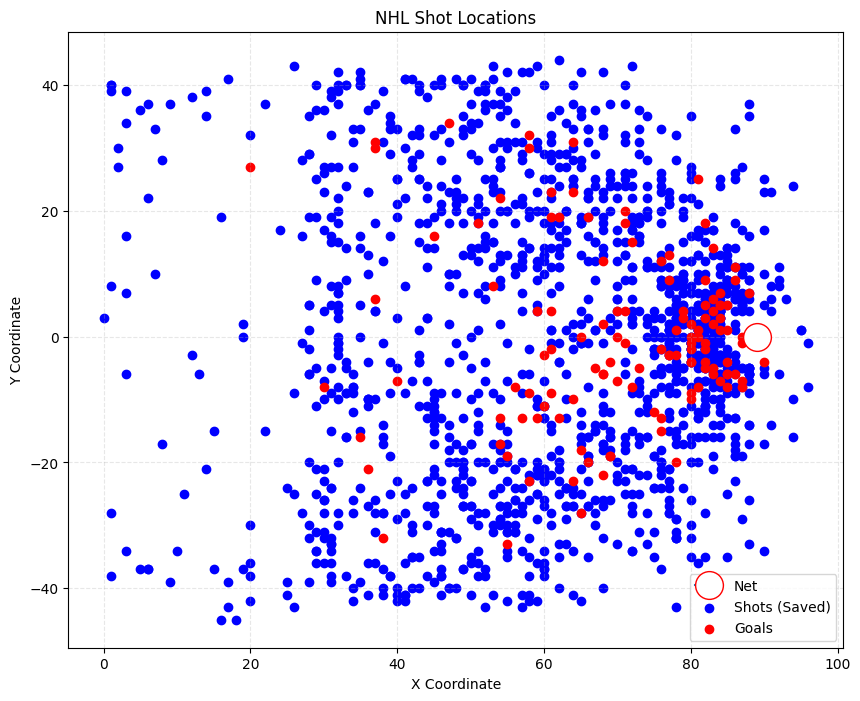

In [3]:
goalie_name = "Thatcher Demko"
goalie_id = goalies_df[goalies_df["name"] == goalie_name]["playerId"].values[0]

example_df = merged_df[merged_df["goalieIdForShot"] == goalie_id]

plt.figure(figsize=(10, 8))

plt.plot(89, 0, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="white", label="Net")

goals = example_df[example_df['goal'] == 1]
non_goals = example_df[example_df['goal'] == 0]

plt.scatter(abs(non_goals['arenaAdjustedXCord']), non_goals['arenaAdjustedYCord'], 
            color='blue', label='Shots (Saved)')

plt.scatter(abs(goals['arenaAdjustedXCord']), goals['arenaAdjustedYCord'], 
            color='red', label='Goals')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NHL Shot Locations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [ ]:
features = ["arenaAdjustedXCord", "arenaAdjustedYCord", "shotDistance", "shotAngle", "shotRebound", "shotWasOnGoal", "shotRush", 
            "shootingTeamDefencemenOnIce", "shootingTeamForwardsOnIce", "playerPositionThatDidEvent", "save_percentage", "xGoals", "xRebounds", "shooterLeftRight", 
            "offWing", "xGoal", "playerId", "shotType", "defendingTeamDefencemenOnIce", "defendingTeamForwardsOnIce"]

X = merged_df[features]
y = merged_df["goal"]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.33)

In [5]:
model = HistGradientBoostingClassifier(random_state=42, class_weight={0:1, 1:5})
model.fit(train_X, train_y)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 5}, random_state=42)

In [6]:
predictions = model.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
mae = mean_absolute_error(test_y.values, predictions)
print(f"Accuracy: {accuracy}\nMean Absolute Error: {mae}")

print(classification_report(test_y, predictions))


Accuracy: 0.7971250045147542
Mean Absolute Error: 0.2028749954852458
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     24988
           1       0.25      0.55      0.34      2699

    accuracy                           0.80     27687
   macro avg       0.60      0.69      0.61     27687
weighted avg       0.88      0.80      0.83     27687



## Visual analysis of model's results

Similar to what I did above, this is a graph that shows us all of the shots the model predicted correctly and incorrectly

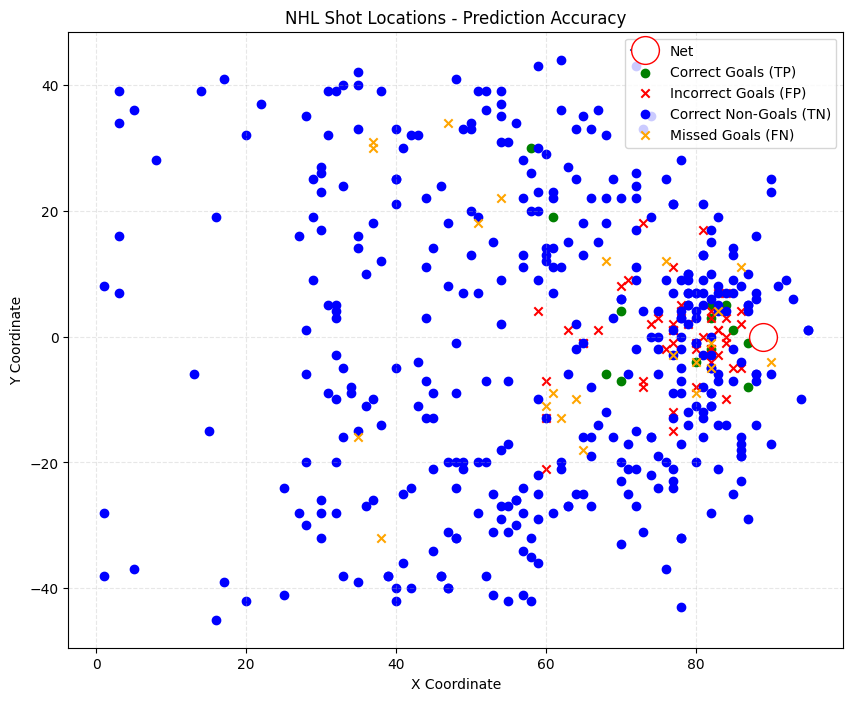

In [7]:
# Thatcher Demko (Canucks LEGEND)
test_X = test_X[test_X["playerId"] == 8477967]

plt.figure(figsize=(10, 8))


plt.plot(89, 0, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="white", label="Net")


correct_goals = (predictions == 1) & (test_y == 1)  # True Positives
incorrect_goals = (predictions == 1) & (test_y == 0)  # False Positives
correct_non_goals = (predictions == 0) & (test_y == 0)  # True Negatives
incorrect_non_goals = (predictions == 0) & (test_y == 1)  # False Negatives


plt.scatter(abs(test_X.loc[correct_goals, 'arenaAdjustedXCord']), 
            test_X.loc[correct_goals, 'arenaAdjustedYCord'], 
            color='green', marker='o', label='Correct Goals (TP)')

plt.scatter(abs(test_X.loc[incorrect_goals, 'arenaAdjustedXCord']), 
            test_X.loc[incorrect_goals, 'arenaAdjustedYCord'], 
            color='red', marker='x', label='Incorrect Goals (FP)')

plt.scatter(abs(test_X.loc[correct_non_goals, 'arenaAdjustedXCord']), 
            test_X.loc[correct_non_goals, 'arenaAdjustedYCord'], 
            color='blue', marker='o', label='Correct Non-Goals (TN)')

plt.scatter(abs(test_X.loc[incorrect_non_goals, 'arenaAdjustedXCord']), 
            test_X.loc[incorrect_non_goals, 'arenaAdjustedYCord'], 
            color='orange', marker='x', label='Missed Goals (FN)')


plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NHL Shot Locations - Prediction Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Using more data

The model above was trained with only 2023 data, the model below is using all NHL shot/goalie data from 2007 till 2023

**NOTE:** The shot data is not included in this repository due to Github's file size limits. You can download it [here](https://peter-tanner.com/moneypuck/downloads/shots_2007-2023.zip)

In [8]:
goalies_df = pd.read_csv("data/goalies_2008-2023.csv")
goalies_df = goalies_df[goalies_df["situation"] == "all"]

goalies_df["save_percentage"] = (goalies_df["ongoal"] - goalies_df["goals"]) / goalies_df["ongoal"]

shots_df = pd.read_csv("data/shots_2007-2023.csv")
shots_df = shots_df[shots_df["shotOnEmptyNet"] == 0]
shots_df = shots_df[shots_df["event"] != "MISS"]

position_mapping = {'C': 0, 'L': 1, 'R': 2, 'D': 3}
shots_df['playerPositionThatDidEvent'] = shots_df['playerPositionThatDidEvent'].map(position_mapping)

wing_mapping = {"R": 0, "L": 1}
shots_df["shooterLeftRight"] = shots_df["shooterLeftRight"].map(wing_mapping)

shot_type_map = {"WRIST": 0, "SNAP": 1, "SLAP": 2, "BACK": 3, "TIP": 4, "DEFL": 5, "WRAP": 6}
shots_df["shotType"] = shots_df["shotType"].map(shot_type_map)

# Merge on both player ID and season to get the correct goalie stats for each season
merged_df = pd.merge(
    shots_df,
    goalies_df,
    left_on=['goalieIdForShot', 'season'],
    right_on=['playerId', 'season'],
    how='left'
)

merged_df.head()

,shotID,homeTeamCode,awayTeamCode,season,isPlayoffGame,game_id,homeTeamWon,id,time,timeUntilNextEvent,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,save_percentage
0,0,TBL,NSH,2023,0,20001,1,10,61,9.0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
1,1,TBL,NSH,2023,0,20001,1,11,70,26.0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
2,2,TBL,NSH,2023,0,20001,1,13,107,2.0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
3,3,TBL,NSH,2023,0,20001,1,19,177,35.0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
4,6,TBL,NSH,2023,0,20001,1,31,435,10.0,...,20.89,26.31,26.95,32.0,34.0,17.0,363.0,0.0,0.0,0.889628


In [9]:
X = merged_df[features]
y = merged_df["goal"]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.33)

In [10]:
model = HistGradientBoostingClassifier(random_state=42, class_weight={0:1, 1:5})
model.fit(train_X, train_y)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 5}, random_state=42)

In [11]:
predictions = model.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
mae = mean_absolute_error(test_y.values, predictions)
print(f"Accuracy: {accuracy}\nMean Absolute Error: {mae}")

print(classification_report(test_y, predictions))

Accuracy: 0.8444615872053779
Mean Absolute Error: 0.15553841279462208
              precision    recall  f1-score   support

           0       0.95      0.88      0.91    396739
           1       0.28      0.49      0.36     38819

    accuracy                           0.84    435558
   macro avg       0.62      0.69      0.64    435558
weighted avg       0.89      0.84      0.86    435558



## Visualization of larger model's predictions

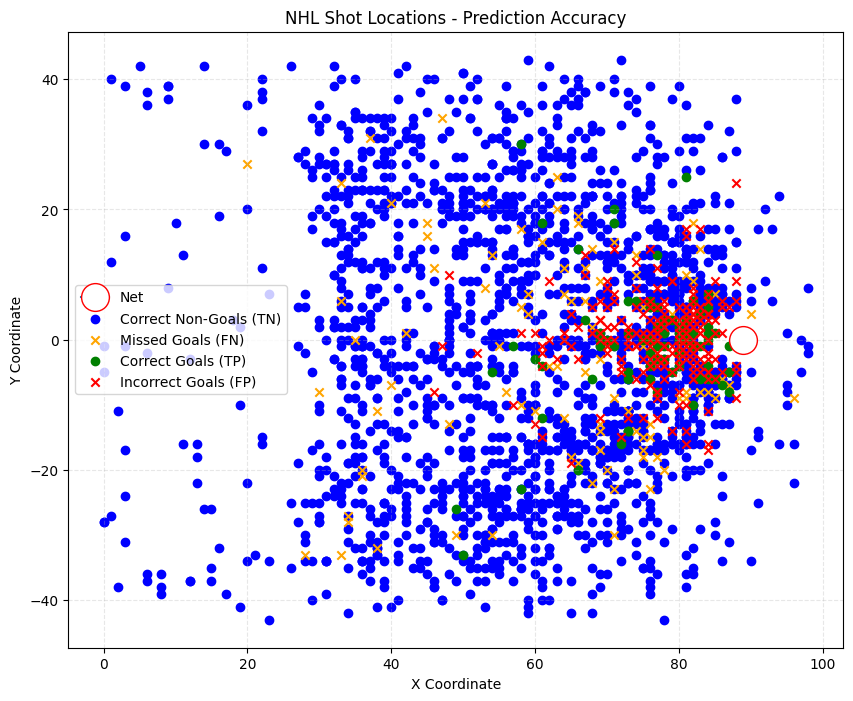

In [12]:
# Thatcher Demko (Canucks LEGEND)
test_X = test_X[test_X["playerId"] == 8477967]

plt.figure(figsize=(10, 8))


plt.plot(89, 0, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="white", label="Net")


correct_goals = (predictions == 1) & (test_y == 1)  # True Positives
incorrect_goals = (predictions == 1) & (test_y == 0)  # False Positives
correct_non_goals = (predictions == 0) & (test_y == 0)  # True Negatives
incorrect_non_goals = (predictions == 0) & (test_y == 1)  # False Negatives

plt.scatter(abs(test_X.loc[correct_non_goals, 'arenaAdjustedXCord']), 
            test_X.loc[correct_non_goals, 'arenaAdjustedYCord'], 
            color='blue', marker='o', label='Correct Non-Goals (TN)')

plt.scatter(abs(test_X.loc[incorrect_non_goals, 'arenaAdjustedXCord']), 
            test_X.loc[incorrect_non_goals, 'arenaAdjustedYCord'], 
            color='orange', marker='x', label='Missed Goals (FN)')

plt.scatter(abs(test_X.loc[correct_goals, 'arenaAdjustedXCord']), 
            test_X.loc[correct_goals, 'arenaAdjustedYCord'], 
            color='green', marker='o', label='Correct Goals (TP)')

plt.scatter(abs(test_X.loc[incorrect_goals, 'arenaAdjustedXCord']), 
            test_X.loc[incorrect_goals, 'arenaAdjustedYCord'], 
            color='red', marker='x', label='Incorrect Goals (FP)')






plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NHL Shot Locations - Prediction Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()